# Basic Grizli tutorial

Here's a quick tutorial on how to use Grizli to simulate grism images. Seaborn is used to make plots look nicer, if you don't have it you can ignore it. 

The only other package that could give you problems is pysynphot. If it does look it up online and make sure you've downloaded all the necessary files for it.

The jupyter magic commands change the resolution to be better suited for macs with retina displays and display the plots inline.

In [1]:
import grizli
import numpy as np
from sim_tools import Scale_model, Gen_sim, Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy.io import fits
import astropy.wcs as pywcs
import pysynphot as S
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Initialize Grizli

In [2]:
## set flt file, we're using a good example galaxy
flt_input = 's47677_flt.fits' 

## Create Grizli model object
sim_g102 = grizli.model.GrismFLT(grism_file='', verbose=False,
                                         direct_file=flt_input,
                                 force_grism='G102')

Create catalog catalog, then remove objects below a certain magnitude limit. It is not important here since our flt file only contains one object, but with real data this is a necessary step.

In [7]:
sim_g102.photutils_detection(detect_thresh=.025, verbose=True, save_detection=True)

c = Table.read('s47677_flt.detect.cat',format='ascii')
sim_g102.catalog = c
keep = sim_g102.catalog['mag'] < 29


s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
s47677_flt: photutils.source_properties


        Use SourceCatalog.to_table() instead. [grizli.utils]


Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
s47677_flt: photutils.source_properties - 1 objects
s47677_flt: save s47677_flt.detect_seg.fits, s47677_flt.detect.cat


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)


# Compute the full model

In [8]:
sim_g102.compute_full_model(ids=c['id'][keep], mags=c['mag'][keep], verbose=False)

Pick the source using its ID from the catalog.

In [9]:
## Grab object near the center of the image
dr = np.sqrt((sim_g102.catalog['x_flt'] - 579) ** 2 + (sim_g102.catalog['y_flt'] - 522) ** 2)
ix = np.argmin(dr)
gid = sim_g102.catalog['id'][ix]

Get cutout

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3428: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


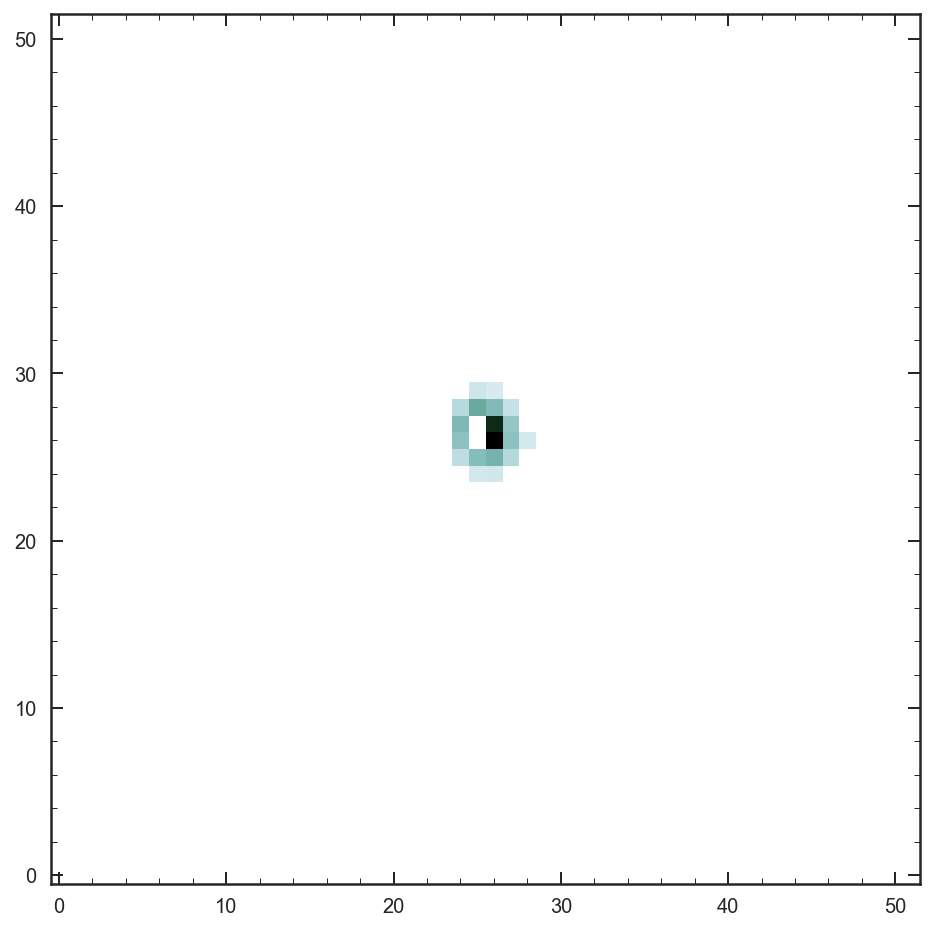

In [10]:
## Spectrum cutouts
beam_g102 = grizli.model.BeamCutout(sim_g102, beam=sim_g102.object_dispersers[gid][2]['A'], conf=sim_g102.conf)

###show cutout
plt.figure(figsize=[8,8])
plt.imshow(beam_g102.beam.direct*(beam_g102.beam.seg == gid), interpolation='Nearest', cmap=colmap, origin='lower')
plt.show()
plt.close()

# Create spectra to forward model 

Here we'll use this simple spectra simulator to model, eventually we'll start using real data.

In [20]:
wv,flx = Gen_spec(np.arange(2000,7000,.1),[4100],[20],maxs=[5E-18])
SNR = 10
er = flx / SNR
redshift = 1.3
wv_obs = wv * (1 + redshift)

# Create simluted grism

In [21]:
## create basis model for sim
spec = S.ArraySpectrum(wv, flx, fluxunits='flam')
spec = spec.redshift(redshift).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f105w'))
spec.convert('flam')

## Compute the models
beam_g102.compute_model(spectrum_1d=[spec.wave, spec.flux])

## Extractions the model (error array here is meaningless)
w, f, e = beam_g102.beam.optimal_extract(beam_g102.model, bin=0)

## Get sensitivity function
sens_wv, sens_fl = [beam_g102.beam.lam, beam_g102.beam.sensitivity / np.max(beam_g102.beam.sensitivity)]

## adjust model flux  
IDX = [U for U in range(len(wv_obs)) if 8000 < wv_obs[U] < 11000]

isens = interp1d(sens_wv, sens_fl)(wv_obs[IDX])

ifl = interp1d(w, f)(wv_obs[IDX])

C = Scale_model(flx[IDX], er[IDX], ifl / isens)

##trim and save outputs
IDX = [U for U in range(len(w)) if 8000 <= w[U] <= 11300]

mfl = C * f[IDX] / sens_fl[IDX]
mwv = w[IDX]
mer =np.mean(f[IDX]) / sens_fl[IDX]
mer /=np.trapz(mer,mwv)
mer *= np.trapz(mfl,mwv) / SNR

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


# Plot 2D and 1D spectra, compare 1D to original.

(8000, 11300)

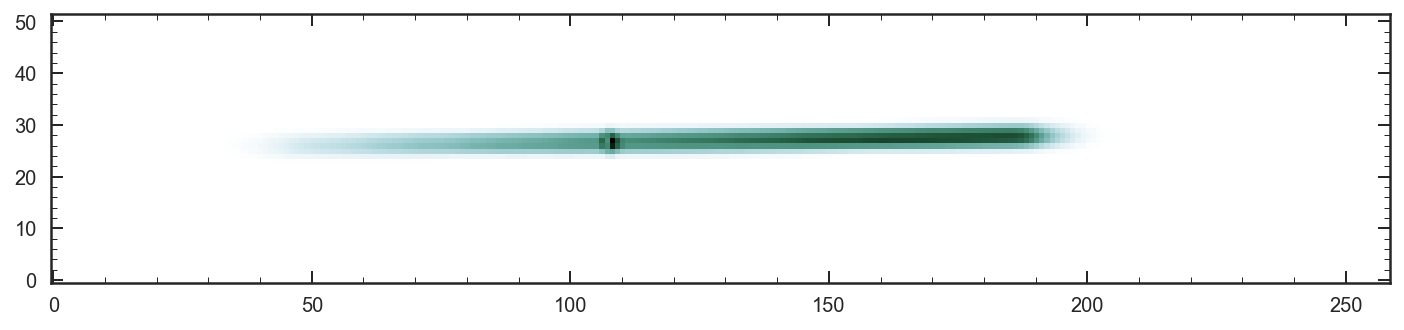

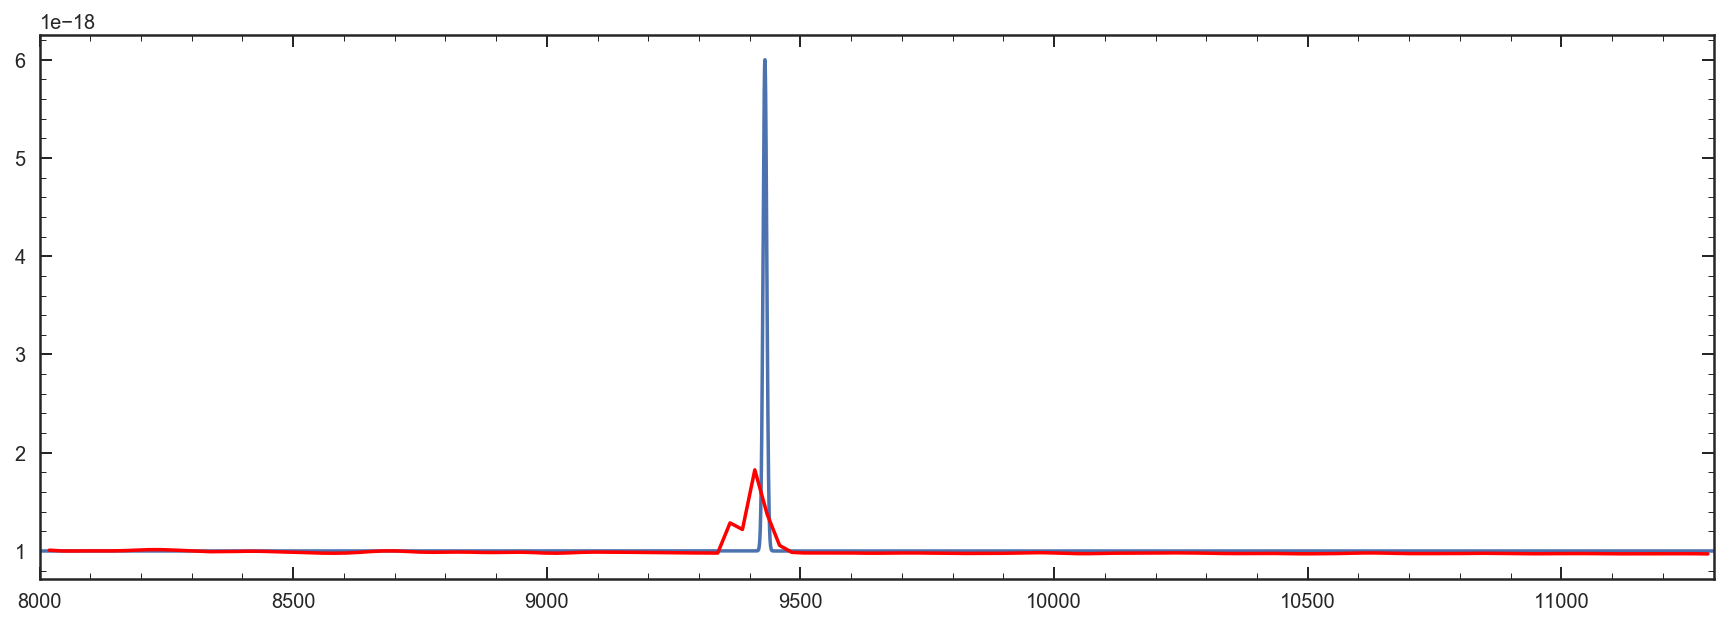

In [22]:
###Show Grism
plt.figure(figsize=[12,8])
plt.subplot(211)
plt.imshow(beam_g102.model, interpolation='Nearest', origin='lower', cmap=colmap)

###plot 1D spectra
plt.figure(figsize=[15,5])
plt.plot(wv_obs,flx)
plt.plot(mwv,mfl,'r')
plt.xlim(8000,11300)

# Second example using premade modules

In [3]:
wv,fl = Gen_spec(np.arange(4000,9000,0.1),[6549,6564,6586],[3,10,2],[2E-18,1E-17,3E-18])

In [4]:
test = Gen_sim(redshift=0.5,wavelength=wv,flux=fl,signal_to_noise=20)

s47677_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
s47677_flt: photutils.source_properties


        Use SourceCatalog.to_table() instead. [grizli.utils]
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/skimage/measure/_moments.py:258: UserWarning: Using deprecated 2D-only, xy-coordinate interface to moments_central. This interface will be removed in scikit-image 0.16. Use moments_central(image, center=(cr, cc), order=3).
  warn(message)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3422: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3427: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf

Rename column: ycentroid -> y_flt
Rename column: xcentroid -> x_flt
s47677_flt: photutils.source_properties - 1 objects
s47677_flt: save s47677_flt.detect_seg.fits, s47677_flt.detect.cat


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [5]:
test.Sim_data()

(8000, 11300)

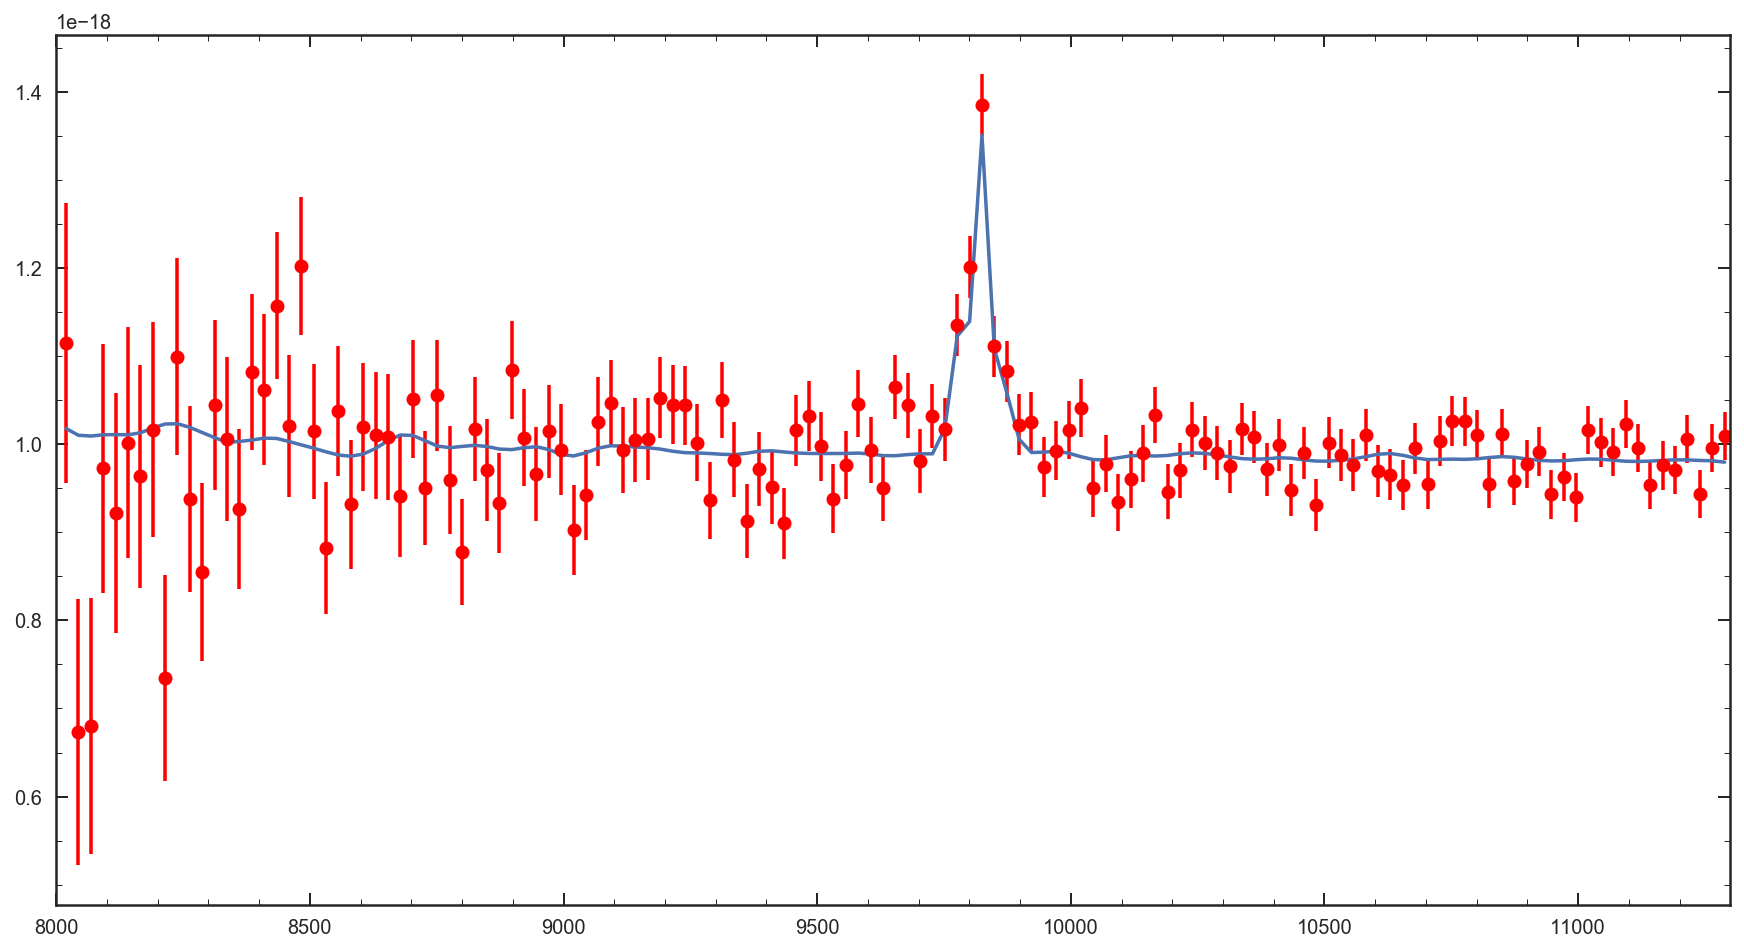

In [6]:
plt.figure(figsize=[15,8])
# plt.plot(test.wv_obs,test.fl)
plt.plot(test.mwv,test.mfl)
plt.errorbar(test.mwv,test.flx_err,test.mer,fmt = 'ro')
plt.xlim(8000,11300)

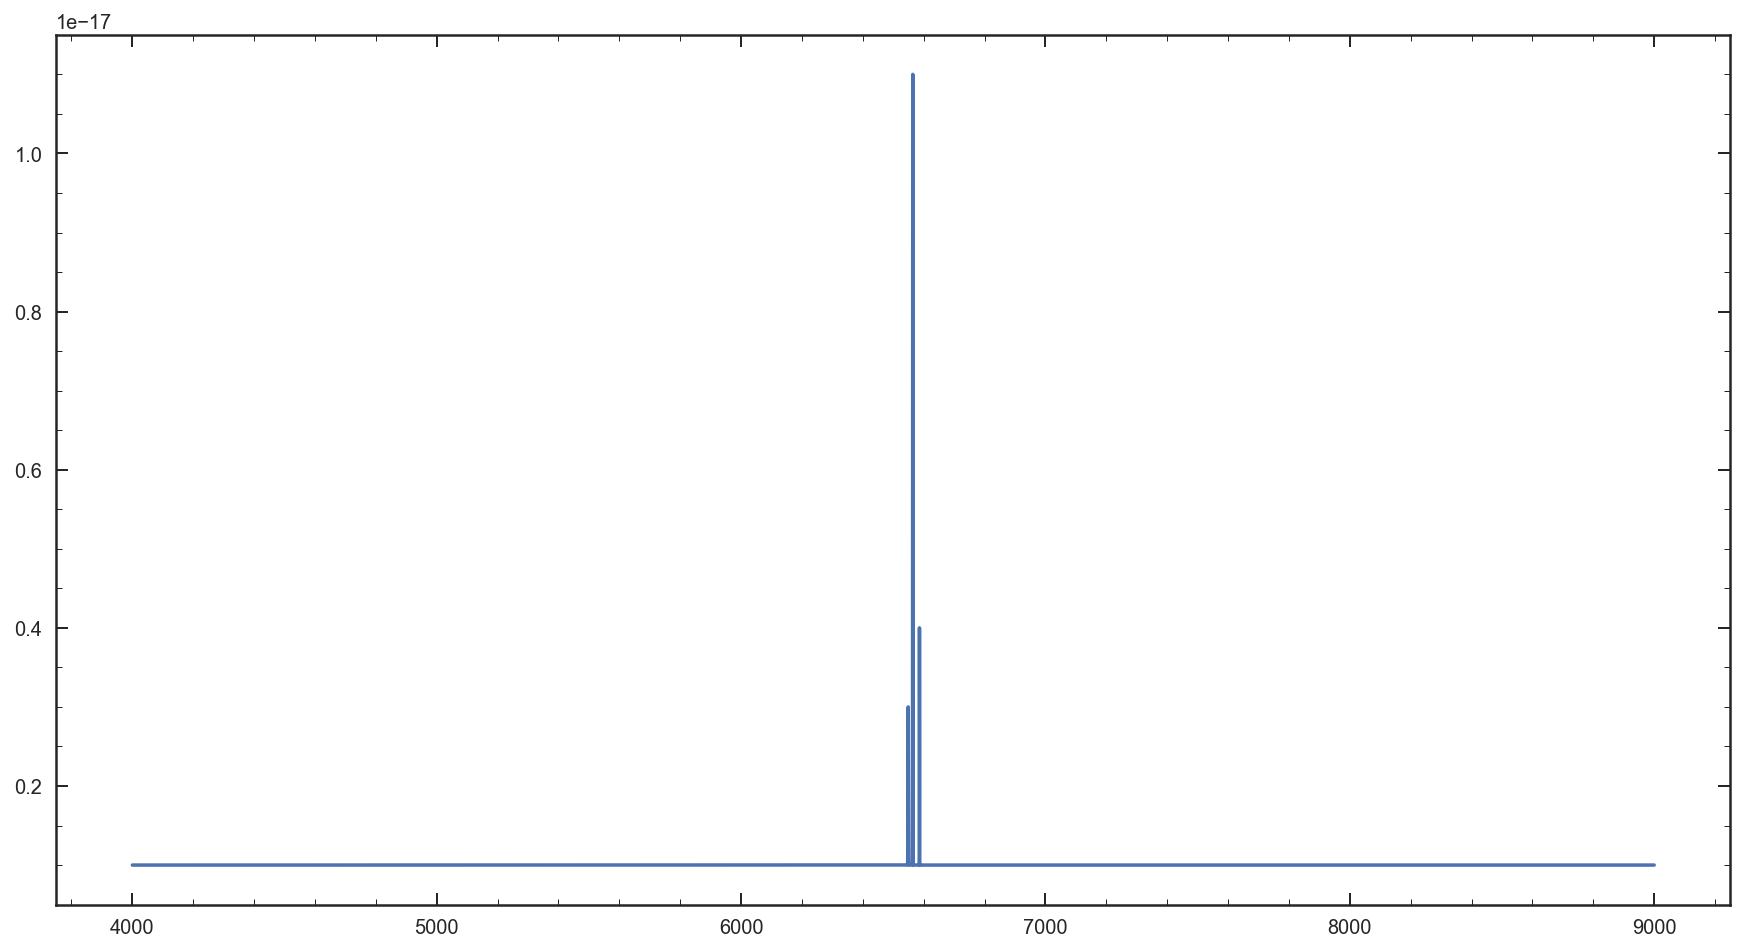

In [7]:
plt.figure(figsize=[15,8])
plt.plot(wv,fl)
# plt.xlim(6000,7000)